In [21]:
from itemrec import ItemRecommender
from euclidean_itemrec import EuclideanItemRecommender
from jaccard_itemrec import JaccardItemRecommender
from song_rec import Song_Rec

import pickle

from collections import Counter

from math import cos

import pandas as pd
import numpy as np

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
sns.set_palette('colorblind')
plt.rcParams.update({'font.size':15})

import warnings
warnings.filterwarnings('ignore')

In [22]:
# reading in all versions of the data

spotify_data = pd.read_csv('../spotify-data/data.csv')
data_by_artist = pd.read_csv('../spotify-data/data_by_artist.csv')
data_by_genre = pd.read_csv('../spotify-data/data_by_genres.csv')
data_by_year = pd.read_csv('../spotify-data/data_by_year.csv')
data_w_genres = pd.read_csv('../spotify-data/data_w_genres.csv')

In [64]:
data_by_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            3232 non-null   object 
 1   acousticness      3232 non-null   float64
 2   danceability      3232 non-null   float64
 3   duration_ms       3232 non-null   float64
 4   energy            3232 non-null   float64
 5   instrumentalness  3232 non-null   float64
 6   liveness          3232 non-null   float64
 7   loudness          3232 non-null   float64
 8   speechiness       3232 non-null   float64
 9   tempo             3232 non-null   float64
 10  valence           3232 non-null   float64
 11  popularity        3232 non-null   float64
 12  key               3232 non-null   int64  
 13  mode              3232 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 353.6+ KB


In [66]:
data_by_genre['genres'].value_counts()

folk rock italiano       1
truck-driving country    1
spanish metal            1
drill and bass           1
dakke dak                1
                        ..
focus beats              1
jig and reel             1
contemporary country     1
gaming dubstep           1
brazilian classical      1
Name: genres, Length: 3232, dtype: int64

Based on above, it looks like there are 3232 unique genres in the dataset

In [23]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

It's looking like the full dataset, `spotify_data`, will be the best bet for building out the recommender because it has the most information.

One potential drawback is that this version of the data don't contain genre information.

`data_w_genres` contains genre information but it's a much smaller dataset... Maybe there's a way to incorporate genre information into the larger dataset.

In [24]:
spotify_data.head()

acousticness                    artists  danceability  duration_ms  energy  \
0      0.991000            ['Mamie Smith']         0.598       168333   0.224   
1      0.643000  ["Screamin' Jay Hawkins"]         0.852       150200   0.517   
2      0.993000            ['Mamie Smith']         0.647       163827   0.186   
3      0.000173        ['Oscar Velazquez']         0.730       422087   0.798   
4      0.295000                   ['Mixe']         0.704       165224   0.707   

   explicit                      id  instrumentalness  key  liveness  \
0         0  0cS0A1fUEUd1EW3FcF8AEI          0.000522    5    0.3790   
1         0  0hbkKFIJm7Z05H8Zl9w30f          0.026400    5    0.0809   
2         0  11m7laMUgmOKqI3oYzuhne          0.000018    0    0.5190   
3         0  19Lc5SfJJ5O1oaxY0fpwfh          0.801000    2    0.1280   
4         1  2hJjbsLCytGsnAHfdsLejp          0.000246   10    0.4020   

   loudness  mode                                               name  \
0   -12.628     0                           Keep A Song In Your Soul   
1    -7.261     0                               I Put A Spell On You   
2   -12.098     1                                       Golfing Papa   
3    -7.311     1  True House Music - Xavier Santos & Carlos Gomi...   
4    -6.036     0                                          Xuniverxe   

   popularity release_date  speechiness    tempo  valence  year  
0          12         1920       0.0936  149.976   0.6340  1920  
1           7   1920-01-05       0.0534   86.889   0.9500  1920  
2           4         1920       0.1740   97.600   0.6890  1920  
3          17   1920-01-01       0.0425  127.997   0.0422  1920  
4           2   1920-10-01       0.0768  122.076   0.2990  1920

In [25]:
# by_date = spotify_data.set_index('release_date')

# fig, ax = plt.subplots(figsize=(12,7))

# ax.plot(by_date.index, by_date['popularity'])
# ax.set_xlabel('Year')
# ax.set_ylabel('Song');

In [26]:
spotify_data['artists'] = spotify_data['artists'].apply(eval).apply(' '.join)
spotify_data['release_date'] = pd.to_datetime(spotify_data['release_date'])
spotify_data['duration_min'] = (spotify_data['duration_ms']/60000).round(2)
spotify_data.drop(columns='duration_ms', inplace=True)
# spotify_data.set_index('artists', inplace=True)
spotify_data.set_index('name', inplace=True)

spotify_data.head()

acousticness  \
name                                                               
Keep A Song In Your Soul                                0.991000   
I Put A Spell On You                                    0.643000   
Golfing Papa                                            0.993000   
True House Music - Xavier Santos & Carlos Gomix...      0.000173   
Xuniverxe                                               0.295000   

                                                                  artists  \
name                                                                        
Keep A Song In Your Soul                                      Mamie Smith   
I Put A Spell On You                                Screamin' Jay Hawkins   
Golfing Papa                                                  Mamie Smith   
True House Music - Xavier Santos & Carlos Gomix...        Oscar Velazquez   
Xuniverxe                                                            Mixe   

                                                    danceability  energy  \
name                                                                       
Keep A Song In Your Soul                                   0.598   0.224   
I Put A Spell On You                                       0.852   0.517   
Golfing Papa                                               0.647   0.186   
True House Music - Xavier Santos & Carlos Gomix...         0.730   0.798   
Xuniverxe                                                  0.704   0.707   

                                                    explicit  \
name                                                           
Keep A Song In Your Soul                                   0   
I Put A Spell On You                                       0   
Golfing Papa                                               0   
True House Music - Xavier Santos & Carlos Gomix...         0   
Xuniverxe                                                  1   

                                                                        id  \
name                                                                         
Keep A Song In Your Soul                            0cS0A1fUEUd1EW3FcF8AEI   
I Put A Spell On You                                0hbkKFIJm7Z05H8Zl9w30f   
Golfing Papa                                        11m7laMUgmOKqI3oYzuhne   
True House Music - Xavier Santos & Carlos Gomix...  19Lc5SfJJ5O1oaxY0fpwfh   
Xuniverxe                                           2hJjbsLCytGsnAHfdsLejp   

                                                    instrumentalness  key  \
name                                                                        
Keep A Song In Your Soul                                    0.000522    5   
I Put A Spell On You                                        0.026400    5   
Golfing Papa                                                0.000018    0   
True House Music - Xavier Santos & Carlos Gomix...          0.801000    2   
Xuniverxe                                                   0.000246   10   

                                                    liveness  loudness  mode  \
name                                                                           
Keep A Song In Your Soul                              0.3790   -12.628     0   
I Put A Spell On You                                  0.0809    -7.261     0   
Golfing Papa                                          0.5190   -12.098     1   
True House Music - Xavier Santos & Carlos Gomix...    0.1280    -7.311     1   
Xuniverxe                                             0.4020    -6.036     0   

                                                    popularity release_date  \
name                                                                          
Keep A Song In Your Soul                                    12         1920   
I Put A Spell On You                                         7   1920-01-05   
Golfing Papa                                                 4         1920   
True House

In [8]:
earliest_song = spotify_data['release_date'].min()
latest_song = spotify_data['release_date'].max()

print(f'The earliest song in the dataset same out on {earliest_song} \n and the most recent song came out on {latest_song}')

The earliest song in the dataset same out on 1920-01-01 00:00:00 
 and the most recent song came out on 2021-01-23 00:00:00


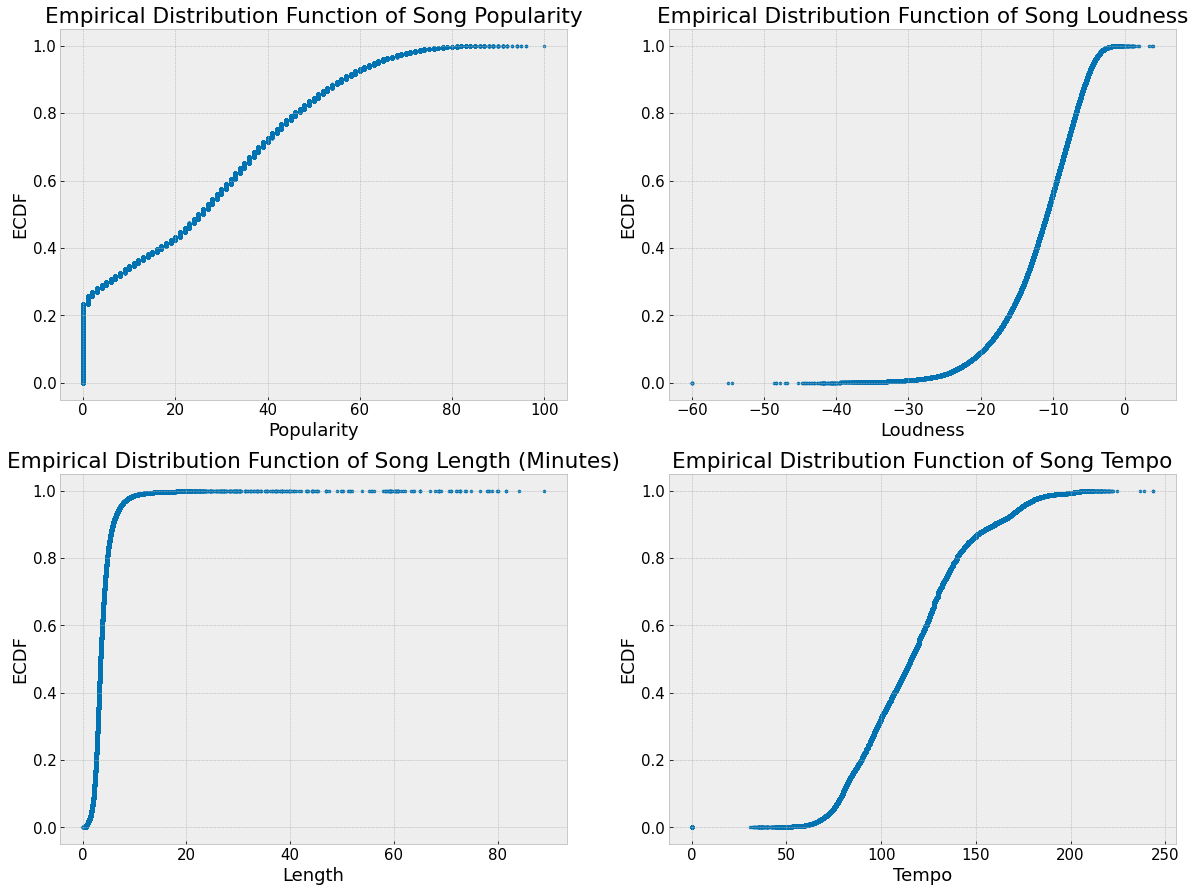

In [9]:
'''
Making ECDF of popularity column
'''

def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, len(x) + 1)/n
    
    return x, y


pop_x, pop_y = ecdf(spotify_data['popularity'])
loud_x, loud_y = ecdf(spotify_data['loudness'])
durat_x, durat_y = ecdf(spotify_data['duration_min'])
temp_x, temp_y = ecdf(spotify_data['tempo'])


fig, ax = plt.subplots(2,2, figsize=(20,15))

ax[0,0].scatter(pop_x, pop_y, label='Popularity', marker='.')
ax[0,0].set_title('Empirical Distribution Function of Song Popularity')
ax[0,0].set_xlabel('Popularity')
ax[0,0].set_ylabel('ECDF')

ax[0,1].scatter(loud_x, loud_y, label='Loudness', marker='.')
ax[0,1].set_title('Empirical Distribution Function of Song Loudness')
ax[0,1].set_xlabel('Loudness')
ax[0,1].set_ylabel('ECDF')

ax[1,0].scatter(durat_x, durat_y, label='Song Length', marker='.')
ax[1,0].set_title('Empirical Distribution Function of Song Length (Minutes)')
ax[1,0].set_xlabel('Length')
ax[1,0].set_ylabel('ECDF')

ax[1,1].scatter(temp_x, temp_y, label='Tempo', marker='.')
ax[1,1].set_title('Empirical Distribution Function of Song Tempo')
ax[1,1].set_xlabel('Tempo')
ax[1,1].set_ylabel('ECDF');


In [10]:
spotify_data.shape

(174389, 18)

In [11]:
artist_agg = spotify_data.groupby('artists').agg(np.mean)
artist_agg.drop(columns=['year','key'], inplace=True)

In [12]:
artist_agg.shape

(36187, 13)

In [13]:
artist_agg.head()

acousticness  danceability    energy  explicit  \
artists                                                                   
"Test for Victor Young"      0.927000      0.734000  0.474000       0.0   
"Weird Al" Yankovic          0.186821      0.650792  0.693189       0.0   
$0dg0d                       0.110000      0.732000  0.822000       1.0   
$NOT                         0.810000      0.847000  0.448000       1.0   
$NOT Flo Milli               0.169000      0.844000  0.720000       1.0   

                         instrumentalness  liveness   loudness      mode  \
artists                                                                    
"Test for Victor Young"          0.076200  0.737000 -10.544000  1.000000   
"Weird Al" Yankovic              0.000045  0.160926  -9.691151  0.735849   
$0dg0d                           0.000009  0.154000  -5.387000  0.000000   
$NOT                             0.000013  0.325000 -10.140000  1.000000   
$NOT Flo Milli                   0.000000  0.079700  -7.418000  0.000000   

                         popularity  speechiness       tempo   valence  \
artists                                                                  
"Test for Victor Young"    3.000000     0.256000  132.788000  0.902000   
"Weird Al" Yankovic       32.867925     0.082275  132.876604  0.764585   
$0dg0d                     0.000000     0.155000  141.948000  0.740000   
$NOT                      77.000000     0.416000   79.975000  0.488000   
$NOT Flo Milli            75.000000     0.300000   99.917000  0.631000   

                         duration_min  
artists                                
"Test for Victor Young"      2.930000  
"Weird Al" Yankovic          3.639434  
$0dg0d                       2.670000  
$NOT                         2.000000  
$NOT Flo Milli               2.100000

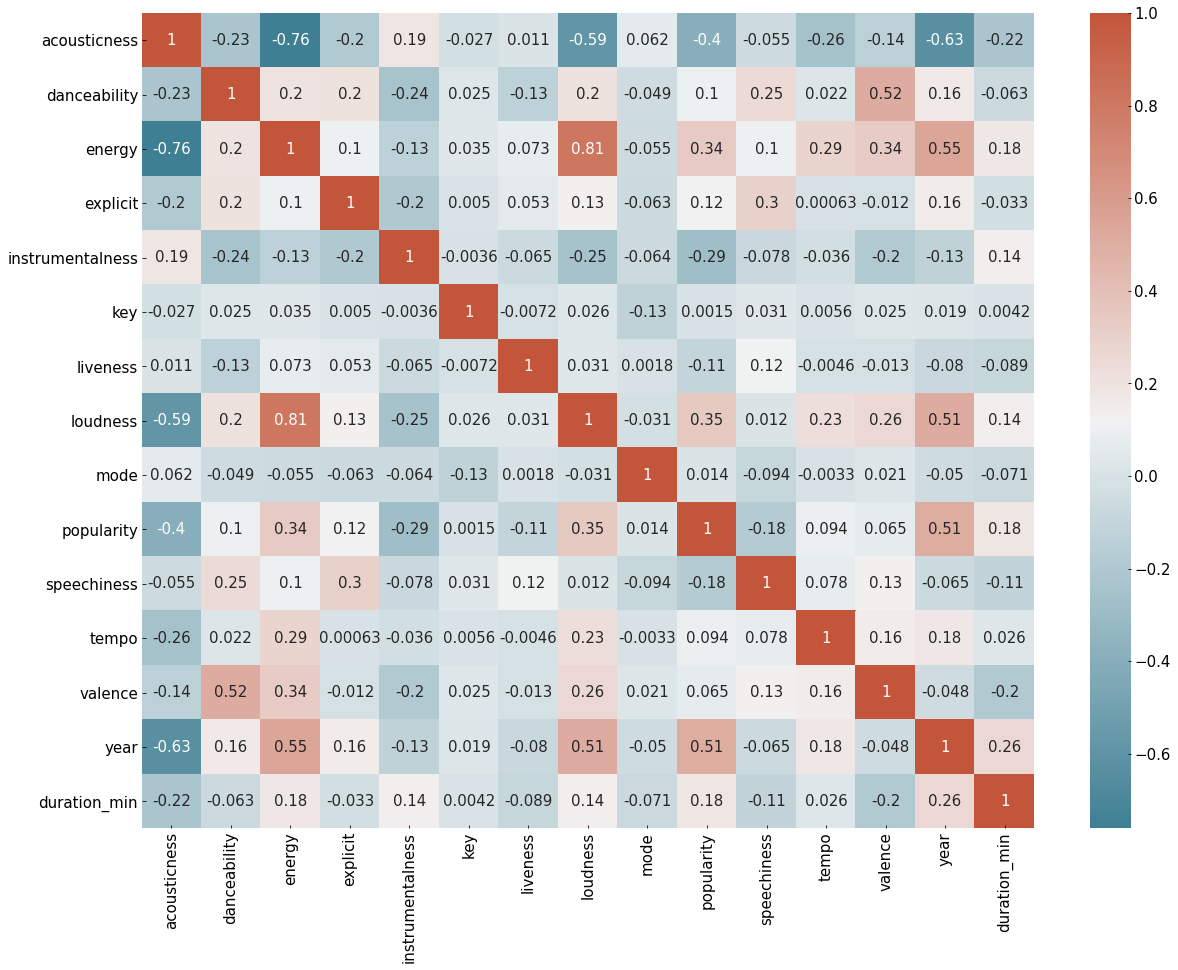

In [14]:
plt.figure(figsize=(20,15))

corr_mat = spotify_data.corr(method='spearman')

# crest = sns.color_palette('crest', as_cmap=True)

div_palette = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(corr_mat, annot=True , cmap=div_palette);

Some notes about the corr matrix:

- valence and danceability: 0.52
- energy and year: 0.55
- energy and popularity: 0.34
- loudness and year: 0.51
- loudness and popularity: 0.35
- loudness and energy: 0.81
- year and popularity: 0.51

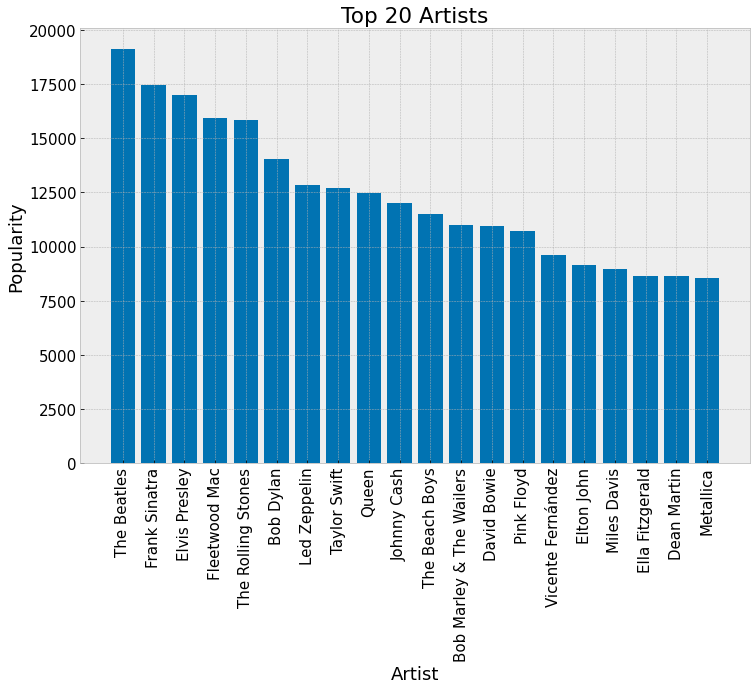

In [15]:
# Most popular Artists

fig, ax = plt.subplots(figsize=(12,8))

pop_artists = spotify_data.groupby('artists')['popularity'].sum().sort_values(ascending=False).head(20)

ax.bar(pop_artists.index, pop_artists)
ax.set_title('Top 20 Artists')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artist')
plt.xticks(rotation=90);

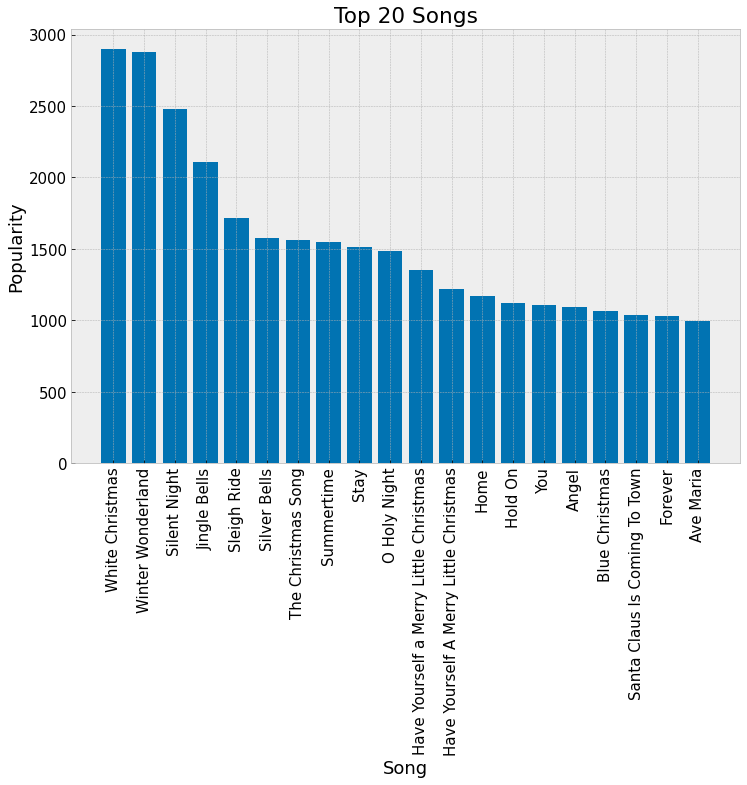

In [16]:
# Most Popular Songs

# Most popular Artists

fig, ax = plt.subplots(figsize=(12,8))

pop_artists = spotify_data.groupby('name')['popularity'].sum().sort_values(ascending=False).head(20)

ax.bar(pop_artists.index, pop_artists)
ax.set_title('Top 20 Songs')
ax.set_ylabel('Popularity')
ax.set_xlabel('Song')
plt.xticks(rotation=90);

## CLUSTERING:

In [67]:
kmeans = KMeans(n_clusters=3232) # based on the genres dataset

data_no_strings = spotify_data.drop(columns=['release_date', 'id','artists'])

In [68]:
kmeans.fit(artist_agg)

KMeans(n_clusters=3232)

In [69]:
kmeans.cluster_centers_

array([[1.01664491e-01, 6.32453689e-01, 7.80850477e-01, ...,
        1.20895293e+02, 5.93044539e-01, 3.86273308e+00],
       [1.05532014e-01, 6.32071429e-01, 8.04357143e-01, ...,
        1.17361929e+02, 5.08278571e-01, 8.09178571e+00],
       [7.48877957e-01, 5.29086957e-01, 3.68342971e-01, ...,
        9.07743952e+01, 4.92963478e-01, 3.15986232e+00],
       ...,
       [8.51799479e-01, 4.24515625e-01, 5.42992187e-02, ...,
        1.06864997e+02, 2.94263802e-01, 3.95143229e+00],
       [8.99000000e-01, 1.76000000e-01, 6.00000000e-03, ...,
        7.14770000e+01, 3.83000000e-02, 1.06000000e+01],
       [7.27267100e-01, 5.67874975e-01, 2.93573227e-01, ...,
        1.18490445e+02, 5.43763283e-01, 3.57033333e+00]])

In [75]:
# features = artist_agg.index

# top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]

# print("top features (artists) for each cluster:")
# for num, centroid in enumerate(top_centroids):
#     artists = [features[i] for i in centroid]
#     print(f"{num}, {', '.join(artists)}")

print('Random sample of artists in each cluster')

assigned_cluster = kmeans.transform(artist_agg).argmin(axis=1)

for i in range(20, 30): # kmeans.n_clusters
    cluster = np.arange(0, artist_agg.shape[0])[assigned_cluster==i]
    sample_artists = np.random.choice(cluster, 5, replace=False)
    print(f"cluster {i}:")
    for artist in sample_artists:
        print(f"         {artist_agg.index[artist]}")

Random sample of artists in each cluster
cluster 20:
         O'Callaghan Kearney
         Kamil Polner
         Selu Vibra
         Jimmie Lunceford
         B&W
cluster 21:
         Dottie West Kenny Rogers
         Diamond Rio
         Chanté Moore
         Gary Hobbs
         Belly
cluster 22:
         Lazlo Bane
         Michael Jackson Paul McCartney
         Dom Kennedy TeeFLii
         Dynamite Hack
         TQ
cluster 23:
         Billie Holiday Benny Carter & His All Star Orchestra
         Miyoshi Umeki Conrad Yama Keye Luke Juanita Hall Rose Quong Salvatore Dell'Isola
         The Southern Serenaders
         Ivie Anderson Duke Ellington Duke Ellington Orchestra
         Johann Strauss I Leopold Weninger Zubin Mehta Wiener Philharmoniker
cluster 24:
         Wale Meek Mill Rick Ross
         Melanie C Lisa "Left Eye" Lopes
         Lloyd Banks Juelz Santana
         Tech N9ne Snug Brim Skatterman
         Paul Wall Big Pokey
cluster 25:
         Maurice Ravel Oscar Levant
 

In [79]:
# maxk = 3232
# wcss = np.zeros(maxk)

distortions = []
K = range(1, 3233)

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(artist_agg)
    distortions.append(kmeans.inertia_)


fig, ax = plt.subplots()

ax.plot(K, distortions, 'o-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('within-cluster sum of squares')

KeyboardInterrupt: 

## CONTENT BASED RECOMMENDER

Let's see if we can build out a content-based recommender just based ont the information we have and the current form of the data...

In [17]:
# normalize column helper function to make all values b/w 0 and 1

def normalize_column(df, col):
    max_d = df[col].max()
    min_d = df[col].min()
    df[col] = (df[col] - min_d)/(max_d-min_d)

In [18]:
# normalizing all numerical data

num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = spotify_data.select_dtypes(include=num_types)

for col in num.columns:
    normalize_column(spotify_data, col)

In [19]:
to_recommend = spotify_data.drop(columns=['id', 'release_date'])

In [20]:
recommender = Song_Rec(to_recommend)

recommender.get_recommendations("Seek & Destroy (Remastered)")

artists
name                                                          
The Big Money                                             Rush
You've Got Everything Now - David Jensen Sessio...  The Smiths
I've Had Enough (Into The Fire)                           KISS
The One Thing                                             INXS
Roulette                                              Bon Jovi

In [21]:
# making a count matrix for the name column

# vectorizer = TfidfVectorizer(stop_words='english')

# mat = vectorizer.fit_transform(spotify_data['name'])

# indices = pd.Series(spotify_data.index)

# # Then creating a dense matrix
# count_df = pd.DataFrame(mat.todense(), index=indices.values)

In [22]:
# mat.shape

In [23]:
# fitting on everything other than id and release_date

# rec = ItemRecommender()

# rec.fit(spotify_data.drop(columns=['id','release_date', 'artists']))

In [24]:
# print(rec.get_recommendations('Keep A Song In Your Soul'))

In [26]:
# normalizing all numerical data

num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = artist_agg.select_dtypes(include=num_types)

for col in num.columns:
    normalize_column(artist_agg, col)

In [27]:
# artist_agg.to_csv('../spotify-data/artist_agg.csv')

## Testing out the recommender using cosine similarity

In [28]:
'''testing out the cosine based recommender on the artist aggregate data'''

recommender = ItemRecommender()

recommender.fit(artist_agg)

## Messing around with some recommendations

In [29]:
print(recommender.get_recommendations('DaBaby', n=10))

['6ix9ine' 'Jasiah' 'Ski Mask The Slump God' 'Megan Thee Stallion'
 'Chief Keef' 'Playboi Carti Lil Uzi Vert' 'Freddie Dredd'
 'YoungBoy Never Broke Again' 'Yung Gravy' 'Kodak Black']


In [30]:
print(recommender.get_recommendations('Nirvana', n=10))

['Van Halen' 'Foo Fighters' 'Stone Temple Pilots' 'Soundgarden'
 'Siouxsie and the Banshees' 'Iggy Pop' 'Slade' 'Black Sabbath'
 'Mötley Crüe' 'Live']


In [31]:
print(recommender.get_recommendations('Pixies', n=10))

['Krokus' 'LCD Soundsystem' 'Suzi Quatro' 'Nazareth' 'Toadies'
 'Creedence Clearwater Revival' 'Love and Rockets' 'Cinderella'
 'The Stranglers' 'Deep Purple']


In [32]:
print(recommender.get_recommendations('Khruangbin', n=10))

['Mr. Scruff Sneaky' 'Hasso Gakudan' 'Mel Brown'
 'The Love Unlimited Orchestra' 'Proleter' 'Poolside' 'The Clean'
 'Toby Fox' 'Bryan Ferry Todd Terje' 'Herbie Mann Duane Allman']


In [33]:
print(recommender.get_recommendations('Sam Cooke', n=10))

['Paul Anka' 'Dion' 'Roy Orbison' 'Porter Wagoner' 'Buddy Greco'
 'Aretha Franklin' 'Etta James' 'Elvis Presley' 'Muddy Waters'
 'The Cascades']


In [34]:
print(recommender.get_recommendations('Daft Punk', n=10))

['Underworld' 'Massive Attack' 'St Germain' 'Moby' 'STRFKR'
 'Thievery Corporation' 'No Vacation' 'deadmau5' 'Kraftwerk' 'The Heavy']


In [36]:
print(recommender.get_recommendations('Cannibal Corpse', n=10))

['Children Of Bodom' 'Mayhem' 'The Danse Society' 'In Flames'
 'Celtic Frost' 'Sadus' 'Dimmu Borgir' 'Otep' 'Saltwater ReOrder'
 'Harvester']


In [37]:
print(recommender.get_recommendations('Cocteau Twins', n=10))

['Built To Spill' 'Bo Hansson' 'Sonic Youth' 'Fugazi'
 'The Velvet Underground Nico' 'The Chemical Brothers' 'David Gilmour'
 'Galaxie 500' 'Hum' 'Melvins']


In [39]:
recommender.get_user_recommendation(['Led Zeppelin', 'The Beatles'], n=10)

array(['Donnie & Joe Emerson', 'The Beatles', 'Lou Reed',
       'George Harrison', 'Blind Melon', 'Dave Matthews Band',
       'Led Zeppelin', 'ABBA', 'John Lennon', 'Elton John'], dtype=object)

Definitely looks like cosine similarity is the way to go

## Testing out the recommender using euclidean distance

In [ ]:
# euc_recommender = EuclideanItemRecommender()

# euc_recommender.fit(artist_agg)

In [ ]:
# print(euc_recommender.get_recommendations('The Smiths', n=10))

In [ ]:
# euc_recommender.get_user_recommendation(['Sonic Youth', 'Pixies', 'Nirvana', 'The Beatles'], n=20)

Okay so euclidean distance definitely doesn't do as well as cosine similarity

## Testing out the recommender using Jaccard

In [ ]:
# Doesn't work

# jacc_recommender = JaccardItemRecommender()

# jacc_recommender.fit(artist_agg)